In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import cv2
from sklearn.model_selection import train_test_split
print ("done")

done


In [3]:


def crop_black_region(img, tol=7):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray > tol
    return img[np.ix_(mask.any(1), mask.any(0))] if mask.any() else img

def enhance_contrast(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    cl = cv2.createCLAHE(clipLimit=2.0).apply(l)
    return cv2.cvtColor(cv2.merge((cl, a, b)), cv2.COLOR_LAB2RGB)

def resize_pad(img, target_size=224):
    h, w = img.shape[:2]
    scale = target_size / max(h, w)
    img = cv2.resize(img, (int(w * scale), int(h * scale)))
    pad_h, pad_w = target_size - img.shape[0], target_size - img.shape[1]
    top, bottom = pad_h // 2, pad_h - pad_h // 2
    left, right = pad_w // 2, pad_w - pad_w // 2
    return cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

def preprocess_image(path, size=224):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_black_region(img)
    img = enhance_contrast(img)
    img = resize_pad(img, size)
    return img.astype(np.float32) / 255.0

def load_images_from_folder(folder, label):
    images, labels = [], []
    for fname in os.listdir(folder):
        img_path = os.path.join(folder, fname)
        img = preprocess_image(img_path)
        images.append(img)
        labels.append(label)
    return images, labels


dr_path = r'C:\Users\onyem\OneDrive\Desktop\FinalYearProject\Data\train\DR'
no_dr_path = r'C:\Users\onyem\OneDrive\Desktop\FinalYearProject\Data\train\No_DR'

X_dr, y_dr = load_images_from_folder(dr_path, 1)
X_no_dr, y_no_dr = load_images_from_folder(no_dr_path, 0)

X = np.array(X_dr + X_no_dr)
y = np.array(y_dr + y_no_dr)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("donee")

donee


Epoch 1/15
52/52 [==============================] - ETA: 0s - loss: 2.3095 - accuracy: 0.8512

C:\Users\onyem\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 141s 3s/step - loss: 2.3095 - accuracy: 0.8512 - val_loss: 26.6221 - val_accuracy: 0.5048
Epoch 2/15
52/52 [==============================] - 126s 2s/step - loss: 0.2296 - accuracy: 0.9199 - val_loss: 49.1965 - val_accuracy: 0.5048
Epoch 3/15
52/52 [==============================] - 122s 2s/step - loss: 0.1948 - accuracy: 0.9325 - val_loss: 57.7080 - val_accuracy: 0.5048
Epoch 4/15
52/52 [==============================] - 120s 2s/step - loss: 0.1722 - accuracy: 0.9434 - val_loss: 48.1486 - val_accuracy: 0.5048
Epoch 5/15
52/52 [==============================] - 1272s 25s/step - loss: 0.1525 - accuracy: 0.9542 - val_loss: 35.5551 - val_accuracy: 0.5048
Epoch 6/15
52/52 [==============================] - 109s 2s/step - loss: 0.1254 - accuracy: 0.9554 - val_loss: 19.9261 - val_accuracy: 0.5048
Epoch 7/15
52/52 [==============================] - 107s 2s/step - loss: 0.1110 - accuracy: 0.9614 - val_loss: 6.4129 - val_accuracy: 0.6130
Epoch 8/15
52/52

<Figure size 1500x500 with 0 Axes>

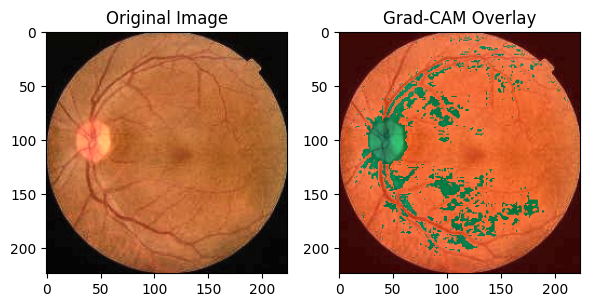

In [6]:

def build_custom_cnn(input_shape=(224, 224, 3), num_classes=2):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, name='conv1'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu', name='conv2'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu', name='conv3'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Flatten(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

model = build_custom_cnn()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_path = 'Retinopathy_model.h5'
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss')
earlystop = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, tf.keras.utils.to_categorical(y_train, 2),
                    validation_data=(X_val, tf.keras.utils.to_categorical(y_val, 2)),
                    epochs=15, batch_size=32,
                    callbacks=[checkpoint, earlystop], verbose=1)

model = load_model(checkpoint_path)
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)

print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", cm)


def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

sample_idx = 0
sample_img = np.expand_dims(X_val[sample_idx], axis=0)
heatmap = make_gradcam_heatmap(sample_img, model, last_conv_layer_name='conv3')
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
overlay = heatmap_color * 0.4 + (X_val[sample_idx] * 255)

cm = [[190, 16],
      [12, 198]]

# Labels for the classes
labels = ['No_DR', 'DR']
plt.figure(figsize=(15, 5))
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(X_val[sample_idx])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(np.uint8(overlay))
plt.title('Grad-CAM Overlay')
plt.tight_layout()
plt.show()



1/1 [==============================] - 0s 78ms/step
Prediction: No_DR (88.32% confidence)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 200ms/step


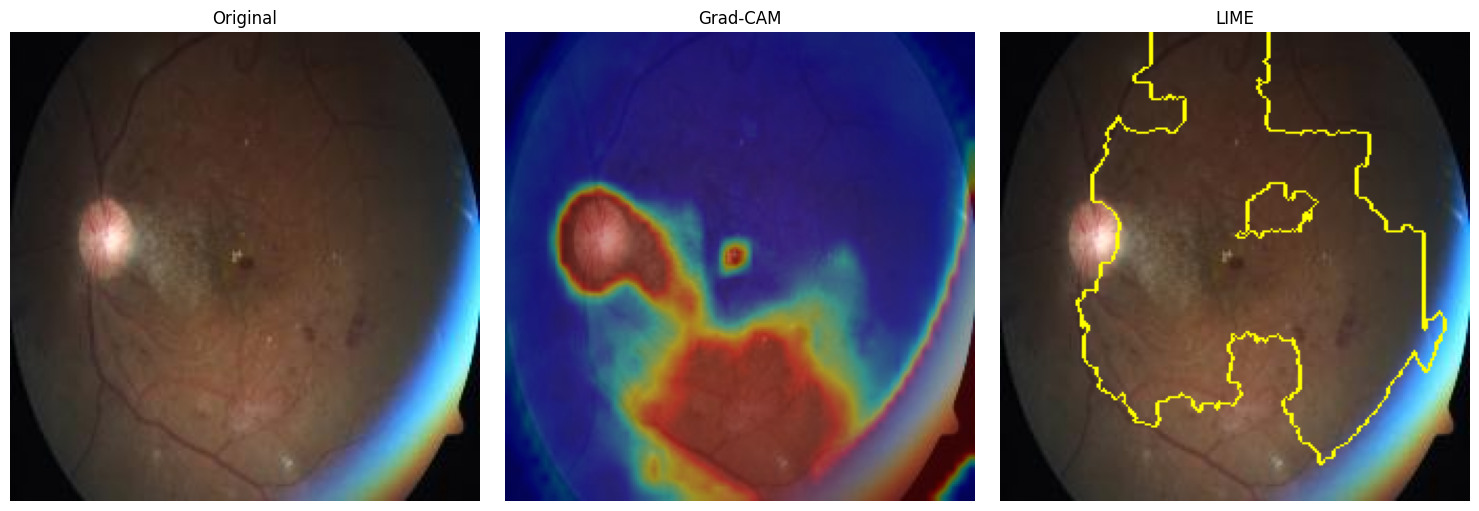

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from lime import lime_image
from skimage.segmentation import mark_boundaries


model_path = r'C:\Users\onyem\OneDrive\Desktop\FinalYearProject\Retinopathy_model.h5'
image_path = r'C:\Users\onyem\OneDrive\Desktop\FinalYearProject\Data\test\DR\0ada12c0e78f_png.rf.3e8e491a2cacb9af201e2f89f3afca61.jpg'
class_names = ['No_DR', 'DR']
img_size = (224, 224)


model = tf.keras.models.load_model(model_path)
model.predict(np.zeros((1, 224, 224, 3)))  


def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    return np.expand_dims(img, axis=0), img

img_array, original_img = preprocess_image(image_path)


prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
confidence = prediction[0][predicted_class]
print(f"Prediction: {class_names[predicted_class]} ({confidence*100:.2f}% confidence)")


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

def display_gradcam(heatmap, original_img, alpha=0.4):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    original_uint8 = np.uint8(original_img * 255)
    overlay = cv2.addWeighted(original_uint8, 1 - alpha, heatmap_color, alpha, 0)
    return overlay

gradcam_output = display_gradcam(heatmap, original_img)


def lime_explanation(img, model):
    explainer = lime_image.LimeImageExplainer()

    def predict_fn(images):
        images = np.array(images) / 255.0
        return model.predict(images)

    explanation = explainer.explain_instance(
        np.uint8(img), 
        predict_fn, 
        top_labels=1, 
        hide_color=0, 
        num_samples=1000
    )

    lime_img, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0], 
        positive_only=True, 
        num_features=10, 
        hide_rest=False
    )
    return mark_boundaries(lime_img, mask)

lime_img = lime_explanation(np.uint8(original_img * 255), model)



plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(original_img)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Grad-CAM")
plt.imshow(gradcam_output)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("LIME")
plt.imshow(lime_img)
plt.axis("off")

plt.tight_layout()
plt.show()


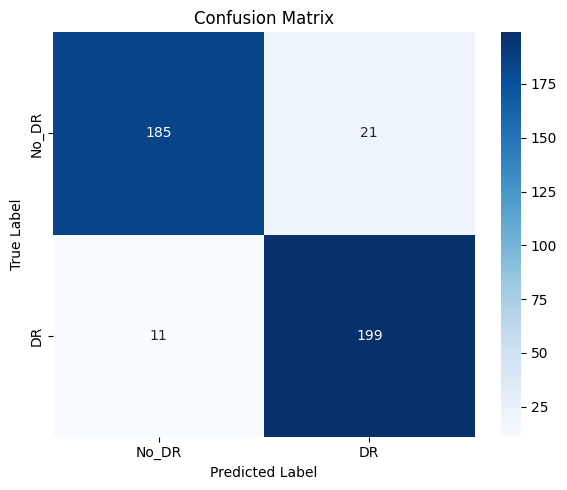

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix values
cm = [[185, 21],
      [11, 199]]

# Labels for the classes
labels = ['No_DR', 'DR']

# Plotting
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()